In [28]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
relax = pd.read_csv("relax.csv", dtype={"time": np.float64})
mpi = pd.read_csv("mpi.csv", dtype={"time": np.float64})

In [4]:
# get average of repeated runs
relax_avg = relax.groupby("n").mean().reset_index()
mpi_avg = mpi.groupby(["n", "cores"]).mean().reset_index()

# convert time from ms to s
relax_avg["time"] = relax_avg["time"].div(1000)
mpi_avg["time"] = mpi_avg["time"].div(1000)

# add row for total number of elements
fn = lambda x: (int)(x["n"] * x["n"])
relax_avg["size"] = relax_avg.apply(fn, axis=1)
mpi_avg["size"] = mpi_avg.apply(fn, axis=1)

# add row for flops
fn = lambda x: (9 * x["iterations"] * x["n"] * x["n"]) / x["time"]
relax_avg["flops"] = relax_avg.apply(fn, axis=1)
mpi_avg["flops"] = mpi_avg.apply(fn, axis=1)

# select only thousands
relax_small = relax_avg[relax_avg["n"] % 1000 == 0]
mpi_small = mpi_avg[mpi_avg["n"] % 1000 == 0]

In [61]:
# combine data
combined = pd.concat([relax_avg, mpi_avg])
combined = combined.fillna(0)
combined = combined.astype({"cores": "int64"})

# add labels
fn = lambda x: "Sequential" if x["cores"] == 0 else f"MPI {x['cores']} cores"
combined["label"] = combined.apply(fn, axis=1)

# select only thousands
combined_small = combined[combined["n"] % 1000 == 0]

,n,iterations,time,flops,cores,label
size,,,,,,
1000000,1000,445,1.7386,2.303578e+09,0,Sequential
4000000,2000,445,5.5600,2.881295e+09,0,Sequential
9000000,3000,445,11.9302,3.021324e+09,0,Sequential
16000000,4000,445,21.6916,2.954139e+09,0,Sequential
25000000,5000,445,33.7542,2.966298e+09,0,Sequential


In [5]:
# set index for plotting
relax_avg.set_index("size", inplace=True)
mpi_avg.set_index("size", inplace=True)

relax_small.set_index("size", inplace=True)
mpi_small.set_index("size", inplace=True)

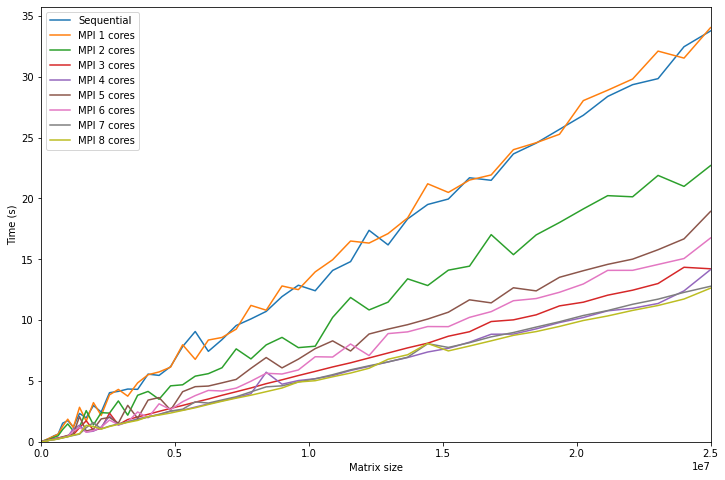

In [6]:
fig, ax = plt.subplots(figsize=(12, 8))

relax_avg["time"].plot(label="Sequential", ax=ax)
for name, group in mpi_avg.groupby("cores"):
    group["time"].plot(label=f"MPI {name} cores", ax=ax)

ax.set_xlabel("Matrix size")
ax.set_ylabel("Time (s)")
ax.set_xlim(0, 5000 * 5000)
ax.set_ylim(bottom=0)

plt.legend()
plt.show()

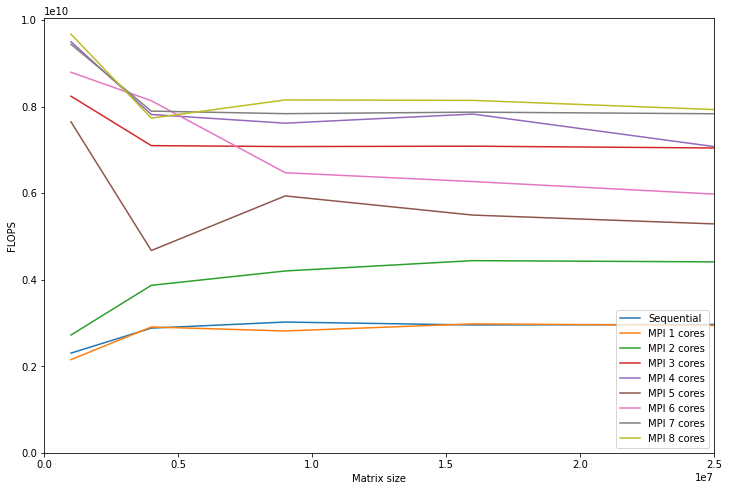

In [9]:
fig, ax = plt.subplots(figsize=(12, 8))

relax_small["flops"].plot(label="Sequential", ax=ax)
for name, group in mpi_small.groupby("cores"):
    group["flops"].plot(label=f"MPI {name} cores", ax=ax)

ax.set_xlabel("Matrix size")
ax.set_ylabel("FLOPS")
ax.set_xlim(0, 5000 * 5000)
ax.set_ylim(bottom=0)

plt.legend()
plt.show()

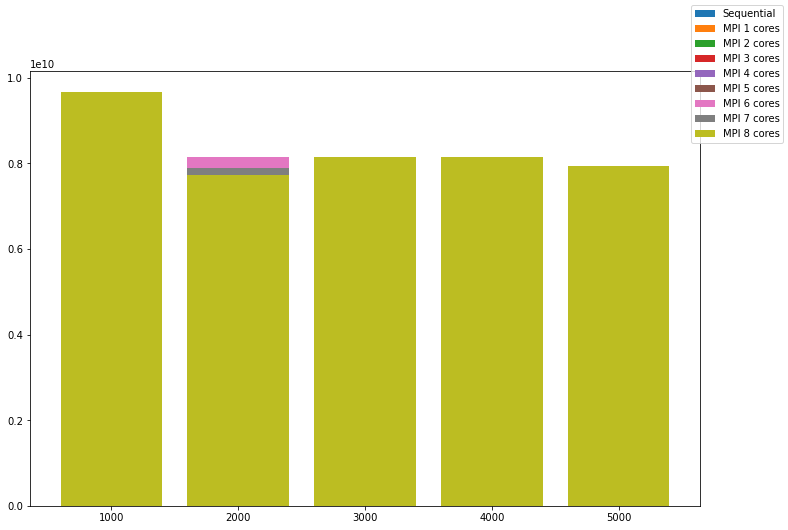

In [29]:
fig = plt.figure(figsize=(12, 8))
ax = fig.add_subplot(111)

ind = ["1000", "2000", "3000", "4000", "5000"]
ax.bar(ind, relax_small["flops"], label="Sequential")
for name, group in mpi_small.groupby("cores"):
    ax.bar(ind, group["flops"], label=f"MPI {name} cores")

fig.legend()
plt.show()

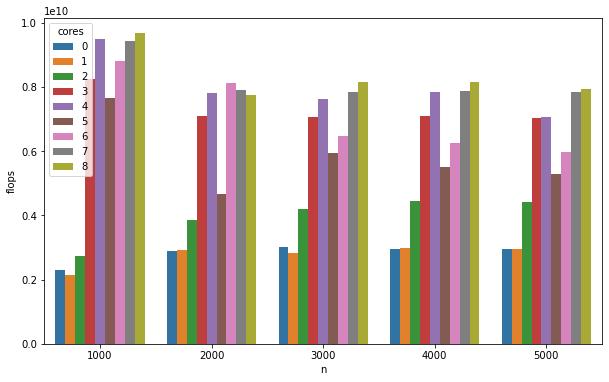

In [55]:
plt.figure(figsize=(10, 6))
sns.barplot(x="n", hue="cores", y="flops", data=combined_small)
plt.show()